## Load parquet

In [1]:
import logging
import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
df = pd.read_parquet("3_years_500_stocks.parquet")

In [3]:
df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
0,1,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,1,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,1,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,1,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [4]:
df.groupby("instrument_id").count()

,ts,open_price,close_price,high_price,low_price,volume
instrument_id,,,,,,
1,85215,85215,85215,85215,85215,85215
2,72120,72120,72120,72120,72120,72120
3,98530,98530,98530,98530,98530,98530
4,119009,119009,119009,119009,119009,119009
5,100777,100777,100777,100777,100777,100777
...,...,...,...,...,...,...
528,1588,1588,1588,1588,1588,1588
530,62633,62633,62633,62633,62633,62633
531,70902,70902,70902,70902,70902,70902


## Analyze single stock

### Create dataset with sliding averages

In [5]:
sliding_window_df = df[df["instrument_id"] == 500]

In [6]:
def preprocess_data(df):
    # Sort values with ts
    df = df.sort_values("ts")
    # Reset index
    df = df.reset_index(drop=True)

    # Add MACD
    df.ta.macd(fast=12,slow=26,signal=9,append=True)

    # Add Stochastic RSI
    df.ta.stochrsi(14,14,3,3,append=True)
    # # Add RSI
    # df.ta.rsi(14,append=True)

    # Rename columns
    df = df.rename(columns={
        "MACD_12_26_9": "MACD",
        "MACDs_12_26_9": "MACDs",
        "MACDh_12_26_9": "MACDh",
        "STOCHRSIk_14_14_3_3": "RSIk",
        "STOCHRSId_14_14_3_3": "RSId",
        # "RSI_14": "RSI",
    })

    # Calc RSI signals
    RSI_oversold_threshold = 20
    RSI_overbouht_threshold = 80

    df["RSI_buy"] = (df["RSIk"].shift() <= RSI_oversold_threshold) &\
        (df["RSIk"].shift() <= df["RSId"].shift()) &\
        (df["RSIk"] > df["RSId"])
    df["RSI_sell"] = (df["RSIk"].shift() >= RSI_overbouht_threshold) &\
        (df["RSIk"].shift() >= df["RSId"].shift()) &\
        (df["RSIk"] < df["RSId"])

    MACD_threshold = 0.001

    df["MACD_buy"] = (df["MACDh"] > MACD_threshold) & (df["MACDh"].shift() < 0)
    df["MACD_sell"] = (df["MACDh"] < -MACD_threshold) & (df["MACDh"].shift() > 0)

    # Fill na
    df = df.fillna(0)

    return df

In [7]:
sliding_window_df = preprocess_data(sliding_window_df)
sliding_window_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume,MACD,MACDh,MACDs,RSIk,RSId,RSI_buy,RSI_sell,MACD_buy,MACD_sell
0,500,2018-01-23 13:50:00+00:00,8.70,8.70,8.70,8.70,344.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1,500,2018-01-23 14:25:00+00:00,8.60,8.61,8.61,8.60,2800.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2,500,2018-01-23 14:30:00+00:00,8.57,8.80,8.80,8.52,120525.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
3,500,2018-01-23 14:35:00+00:00,8.83,8.62,8.83,8.61,13035.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
4,500,2018-01-23 14:40:00+00:00,8.59,8.40,8.60,8.38,53673.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


Show MACD RSI

In [8]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0
    
    if start_point != 0:
        # Draw and reset
        ax.axvspan(start_point, end_point, alpha=alpha, color=color)
        start_point = 0
        end_point = 0

In [9]:
def plot_candles(df):
    width=1
    width2=0.2

    pricesup = df[df["close_price"] >= df["open_price"]]
    pricesdown = df[df["close_price"] < df["open_price"]]

    plt.bar(pricesup.index, pricesup["close_price"] - pricesup["open_price"], width, bottom=pricesup["open_price"], color='g')
    plt.bar(pricesup.index, pricesup["high_price"] - pricesup["close_price"], width2, bottom=pricesup["close_price"], color='g')
    plt.bar(pricesup.index, pricesup["low_price"] - pricesup["open_price"], width2, bottom=pricesup["open_price"], color='g')

    plt.bar(pricesdown.index, pricesdown["close_price"] - pricesdown["open_price"], width, bottom=pricesdown["open_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["high_price"] - pricesdown["close_price"], width2, bottom=pricesdown["close_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["low_price"] - pricesdown["open_price"], width2, bottom=pricesdown["open_price"], color='r')
    plt.grid()

### Plot Signals

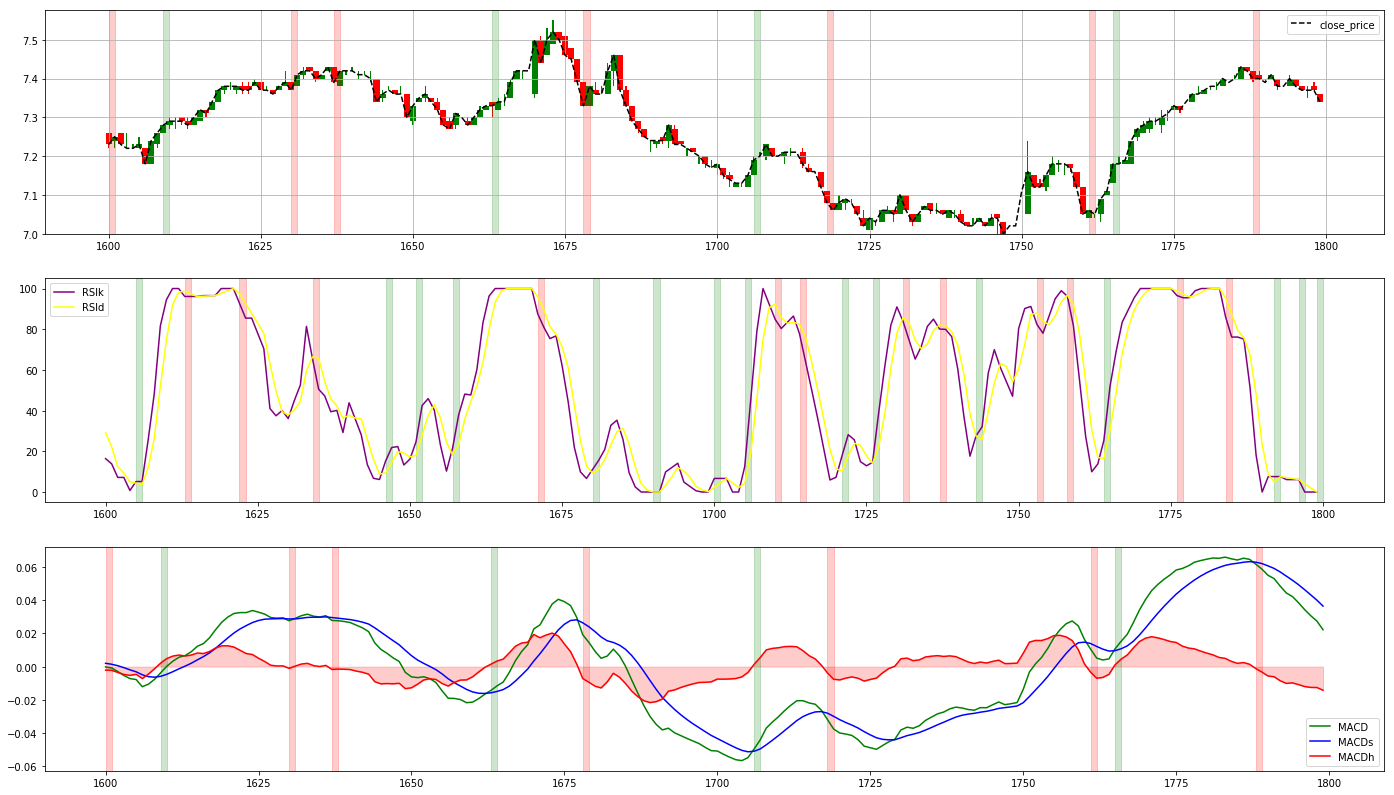

In [10]:
logging.getLogger().setLevel(logging.INFO)

plot_df = sliding_window_df.iloc[1600:1800]

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
ax = plot_df["close_price"].plot(color="black", linestyle='--')
plot_candles(plot_df)
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSIk"].plot(color="purple")
ax1 = plot_df["RSId"].plot(color="yellow")
# Show buy signals
for x in plot_df[plot_df["RSI_buy"]].index:
    ax1.axvspan(x, x+1, alpha=0.2, color="green")      
# Show sell signals
for x in plot_df[plot_df["RSI_sell"]].index: 
    ax1.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

plt.subplot(3, 1, 3)
ax3 = plot_df["MACD"].plot(color="green")
plot_df["MACDs"].plot(ax=ax3,color="blue")
plot_df["MACDh"].plot(ax=ax3,color="red")
ax3.fill_between(plot_df.index, plot_df["MACDh"], alpha=0.2, color="red")
# Show buy signals
for x in plot_df[plot_df["MACD_buy"]].index:
    ax.axvspan(x, x+1, alpha=0.2, color="green")   
    ax3.axvspan(x, x+1, alpha=0.2, color="green")      
# Show sell signals
for x in plot_df[plot_df["MACD_sell"]].index: 
    ax.axvspan(x, x+1, alpha=0.2, color="red")
    ax3.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

# Create manual bot

In [16]:
# Create dataset for bot
# Preprocess data
bot_df = preprocess_data(df[df["instrument_id"] == 1]).iloc[:500]
# Select columns
# bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACDh","RSI"]]
bot_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume,MACD,MACDh,MACDs,RSIk,RSId,RSI_buy,RSI_sell,MACD_buy,MACD_sell
0,1,2018-01-23 11:05:00+00:00,114.50,114.50,114.50,114.50,1.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1,1,2018-01-23 11:10:00+00:00,114.27,114.27,114.27,114.27,2.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2,1,2018-01-23 13:40:00+00:00,114.00,114.00,114.00,114.00,18.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
3,1,2018-01-23 13:45:00+00:00,114.00,114.00,114.00,114.00,882.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
4,1,2018-01-23 13:50:00+00:00,113.82,113.82,113.82,113.82,100.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [19]:
logging.getLogger().setLevel(logging.DEBUG)

from bot import TradingBot

# Test bot
bot = TradingBot(initial_budget=1000,
                rsi_oversold_threshold=20,
                rsi_overbought_threshold=80,
                stop_loss=0.005)
bot.reset()

for index, data in bot_df.iterrows():
    result = bot.process(data["open_price"],
                        data["close_price"],
                        data["RSIk"],
                        data["RSId"],
                        data["MACDh"])

    bot_df.loc[index,"op"] = result

bot.profit * 100

DEBUG:root:Step: 17 Buy 8 with price=113.540000
DEBUG:root:Step: 29 Sell 8 with price=114.340000 with profit 0.70% and overall 0.55%
DEBUG:root:Step: 39 Buy 8 with price=114.270000
DEBUG:root:Step: 57 Sell 8 with price=114.590000 with profit 0.28% and overall 0.71%
DEBUG:root:Step: 69 Buy 8 with price=114.490000
DEBUG:root:Step: 75 Sell 8 with price=114.430000 with profit -0.05% and overall 0.57%
DEBUG:root:Step: 80 Buy 8 with price=114.320000
DEBUG:root:Step: 94 Sell 8 with price=115.580000 with profit 1.10% and overall 1.49%
DEBUG:root:Step: 123 Buy 8 with price=115.620000
DEBUG:root:Step: 140 Sell 8 with price=115.740000 with profit 0.10% and overall 1.49%
DEBUG:root:Step: 157 Buy 8 with price=114.280000
DEBUG:root:Step: 188 Sell 8 with price=108.360000 with profit -5.18% and overall -3.33%
DEBUG:root:Step: 237 Buy 8 with price=112.000000
DEBUG:root:Step: 255 Sell 8 with price=112.390000 with profit 0.35% and overall -3.11%
DEBUG:root:Step: 285 Buy 8 with price=114.560000
DEBUG:root

-3.9601639999998612

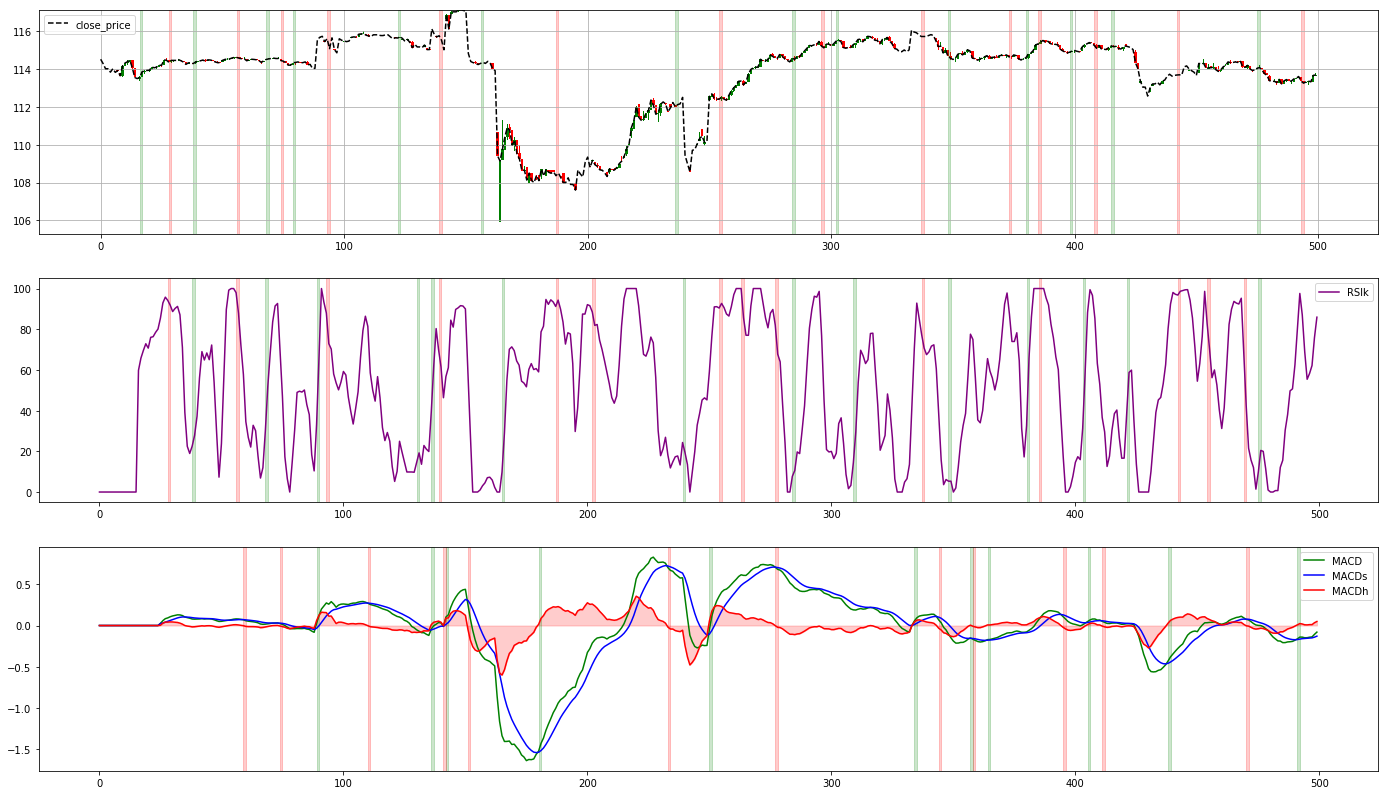

In [20]:
logging.getLogger().setLevel(logging.INFO)

plot_df = bot_df

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
ax = plot_df["close_price"].plot(color="black", linestyle='--')
plot_candles(bot_df)
# Show crossover moments
for x in plot_df[plot_df["op"] == 1].index:
    ax.axvspan(x, x+1, alpha=0.2, color="green")   
# Show crossunder moments
for x in plot_df[plot_df["op"] == 2].index: 
    ax.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSIk"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_buy"]].index, 0.2, "green")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_sell"]].index, 0.2, "red")
plt.legend()

plt.subplot(3, 1, 3)
ax3 = plot_df["MACD"].plot(color="green")
plot_df["MACDs"].plot(ax=ax3,color="blue")
plot_df["MACDh"].plot(ax=ax3,color="red")
ax3.fill_between(plot_df.index, plot_df["MACDh"], alpha=0.2, color="red")
# Show crossover moments
for x in plot_df[plot_df["MACD_buy"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="green")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_sell"]].index: 
    ax3.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

# Test bot on different stocks

In [33]:
def test_bot_profit(df):
    # Preprocess data
    bot_df = preprocess_data(df)
    # Select columns
    bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACDh","RSI"]]

    # Create bot instance
    bot = TradingBot(rsi_oversold_threshold=20,
                    rsi_overbought_threshold=80,
                    stop_loss=0.005)
    # Reset bot
    bot.reset()
    # Run bot
    for index, data in bot_df.iterrows():
        bot.process(data)

    return bot.profit * 100

In [34]:
instruments_df = pd.read_parquet("instruments.parquet")
instruments_df.head()

,name,id,figi
0,JPMorgan,1,BBG000DMBXR2
1,Berkshire Hathaway,2,BBG000DWG505
2,Bank of America Corp,3,BBG000BCTLF6
3,Apple,4,BBG000B9XRY4
4,AT&T,5,BBG000BSJK37


In [35]:
logging.getLogger().setLevel(logging.INFO)

from joblib import Parallel, delayed, parallel_backend

jobs = []

def thread_func(stock_id, stock_df):
    # Check size of dataset
    if stock_df.shape[0] > 8 * 60:
        profit = test_bot_profit(stock_df)

        return {"id":stock_id,"profit":profit}
    
    return {}

with parallel_backend("multiprocessing", n_jobs=12):
    bot_profit_list = Parallel()(delayed(thread_func)(stock_id, stock_df) for stock_id, stock_df in df.groupby("instrument_id"))

bot_profit_df = pd.DataFrame(bot_profit_list).dropna()

bot_profit_df = pd.merge(instruments_df,bot_profit_df,on="id")
 
bot_profit_df

,name,id,figi,profit
0,JPMorgan,1,BBG000DMBXR2,-91.608422
1,Berkshire Hathaway,2,BBG000DWG505,-83.100747
2,Bank of America Corp,3,BBG000BCTLF6,-98.025252
3,Apple,4,BBG000B9XRY4,-93.993793
4,AT&T,5,BBG000BSJK37,-97.327015
...,...,...,...,...
519,Credit Bank of Moscow,528,BBG00RHTYB60,-5.879495
520,Cabot Oil & Gas,530,BBG000C3GN47,-98.404399
521,L Brands,531,BBG000BNGTQ7,-98.975645
522,Slack Technologies Inc,532,BBG007G7V505,-70.268914


In [36]:
bot_profit_df.sort_values("profit")

,name,id,figi,profit
492,Frontier Communications,500,BBG000FH5YM1,-99.996739
393,VEON,396,BBG000QCW561,-99.879785
206,Nokia,208,BBG000BNGBW9,-99.760536
505,Coty,513,BBG000F395V1,-99.732985
361,LG Display,363,BBG000FJ0RK9,-99.626331
...,...,...,...,...
9,Amazon.com,10,BBG000BVPV84,0.000000
19,Gazprom,20,BBG00008WPG3,0.000000
16,Gazprom,17,BBG0000JWX54,0.000000
43,Lukoil,44,BBG0000J5D76,0.000000


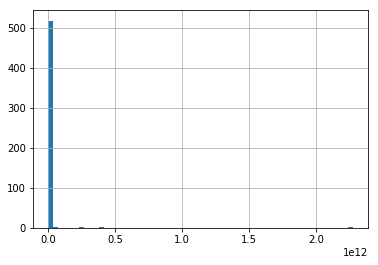

In [18]:
bot_profit_df["profit"].hist(bins=60)

In [19]:
bot_profit_df.describe()

,id,profit
count,524.000000,5.240000e+02
mean,264.240458,1.096103e+10
std,153.072320,1.422422e+11
min,1.000000,-9.220445e+00
25%,132.750000,3.362891e+04
50%,263.500000,2.088048e+05
75%,394.500000,1.749235e+06
max,533.000000,2.274152e+12
